In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import mysql.connector
import os
import re
import sys
import logging
import pandas as pd
import numpy as np
import nltk.data
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from gensim.models import word2vec
from sklearn import naive_bayes, svm, preprocessing
from sklearn.decomposition import TruncatedSVD
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection.univariate_selection import chi2, SelectKBest
from ipywidgets import interact, FloatSlider, Select, Dropdown, widgets

/Users/yy/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/yy/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
os.chdir("/Users/yy/Documents/Dongxf/liu/sentiment-analysis-master")


In [3]:
db = mysql.connector.connect(host="localhost",
                     user="root",
                     passwd="850718",
                     db="oscar", use_unicode=True, charset="utf8") # name of the data base
cur = db.cursor()

In [10]:
write_to_csv = True
# term_vector_type = {"TFIDF", "Binary", "Int", "Word2vec", "Word2vec_pretrained"}
# {"TFIDF", "Int", "Binary"}: Bag-of-words model with {tf-idf, word counts, presence/absence} representation
# {"Word2vec", "Word2vec_pretrained"}: Google word2vec representation {without, with} pre-trained models
# Specify model_name if there's a pre-trained model to be loaded
vector_type = "TFIDF"
model_name = "GoogleNews-vectors-negative300.bin"

# model_type = {"bin", "reg"}
# Specify whether pre-trained word2vec model is binary
model_type = "bin"
   
# Parameters for word2vec
# num_features need to be identical with the pre-trained model
num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count to be included for training                      
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# training_model = {"RF", "NB", "SVM", "BT", "no"}
training_model = "SVM"

# feature scaling = {"standard", "signed", "unsigned", "no"}
# Note: Scaling is needed for SVM
scaling = "standard"

# dimension reduction = {"SVD", "chi2", "no"}
# Note: For NB models, we cannot perform truncated SVD as it will make input negative
# chi2 is the feature selectioin based on chi2 independence test
dim_reduce = "chi2"
num_dim = 500

##################### End of Initialization #####################

In [11]:
def clean_review(raw_review, remove_stopwords = False, output_format = "string"):
    """
    Input:
            raw_review: raw text of a movie review
            remove_stopwords: a boolean variable to indicate whether to remove stop words
            output_format: if "string", return a cleaned string 
                           if "list", a list of words extracted from cleaned string.
    Output:
            Cleaned string or list.
    """
    
    # Remove HTML markup
    text = BeautifulSoup(raw_review, "lxml")
    
    # Keep only characters
    text = re.sub("[^a-zA-Z]", " ", text.get_text())
    
    # Split words and store to list
    text = text.lower().split()
    
    if remove_stopwords:
    
        # Use set as it has O(1) lookup time
        stops = set(stopwords.words("english"))
        words = [w for w in text if w not in stops]
    
    else:
        words = text
    
    # Return a cleaned string or list
    if output_format == "string":
        return " ".join(words)
        
    elif output_format == "list":
        return words
    
    
def review_to_doublelist(review, tokenizer, remove_stopwords = False):
    """
    Function which generates a list of lists of words from a review for word2vec uses.
    
    Input:
        review: raw text of a movie review
        tokenizer: tokenizer for sentence parsing
                   nltk.data.load('tokenizers/punkt/english.pickle')
        remove_stopwords: a boolean variable to indicate whether to remove stop words
    
    Output:
        A list of lists.
        The outer list consists of all sentences in a review.
        The inner list consists of all words in a sentence.
    """
    
    # Create a list of sentences
    raw_sentences = tokenizer.tokenize(review.strip())
    sentence_list = []
    
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentence_list.append(clean_review(raw_sentence, False, "list"))         
    return sentence_list


def review_to_vec(words, model, num_features):
    """
    Function which generates a feature vector for the given review.
    
    Input:
        words: a list of words extracted from a review
        model: trained word2vec model
        num_features: dimension of word2vec vectors
        
    Output:
        a numpy array representing the review
    """
    
    feature_vec = np.zeros((num_features), dtype="float32")
    word_count = 0
    
    # index2word is a list consisting of all words in the vocabulary
    # Convert list to set for speed
    index2word_set = set(model.index2word)
    
    for word in words:
        if word in index2word_set: 
            word_count += 1
            feature_vec += model[word]

    feature_vec /= word_count
    return feature_vec
    
    
def gen_review_vecs(reviews, model, num_features):
    """
    Function which generates a m-by-n numpy array from all reviews,
    where m is len(reviews), and n is num_feature
    
    Input:
            reviews: a list of lists. 
                     Inner lists are words from each review.
                     Outer lists consist of all reviews
            model: trained word2vec model
            num_feature: dimension of word2vec vectors
    Output: m-by-n numpy array, where m is len(review) and n is num_feature
    """

    curr_index = 0
    review_feature_vecs = np.zeros((len(reviews), num_features), dtype="float32")

    for review in reviews:

       if curr_index%1000 == 0.:
           print ("Vectorizing review %d of %d" % (curr_index, len(reviews)))
   
       review_feature_vecs[curr_index] = review_to_vec(review, model, num_features)
       curr_index += 1
       
    return review_feature_vecs
    
    
##################### End of Function Definition #####################

In [12]:
from IPython.display import display

movieReviews = widgets.Text(description="MovieID", width=200)


In [13]:

def  movie_reviews_sentiment(b):
    
    if movieReviews.value!='':
        
        m = movieReviews.value
        print (m)
        cur.execute("SELECT * FROM topvoted10000  where movieID=%s"%(m))
        row2 =  cur.fetchall()
        movieName = []
        for row in row2:
            movieName.append(row[1].decode('utf-8'))
        print ("Movie Name:" + movieName[0])

        train_list = []
        test_list = []
        word2vec_input = []
        pred = []

        train_data = pd.read_csv("labeledTrainData.tsv", header=0, delimiter="\t", quoting=0)
        #test_data = pd.read_csv("testData.tsv", header=0, delimiter="\t", quoting=0)


        sql = cur.execute("SELECT movieID, authorID, reviewContent, reviewersMovieRating, movieName, reviewTitle FROM top10000_reviews_all where movieID=%s"%(m))
        row1 =  cur.fetchall()
        testData_movieID = []
        testData_authorID = []
        testData_review = []
        testData_rating = []
        teseData_movieName = []
        teseData_reviewTitle = []

        for row in row1:
            testData_movieID.append(bytes(row[0]).decode('utf-8'))
        for row in row1:
            testData_authorID.append(bytes(row[1]).decode('utf-8'))
        for row in row1:
            testData_review.append(row[2])
        for row in row1:
            testData_rating.append(bytes(row[3]).decode('utf-8'))
        for row in row1:
            teseData_movieName.append(bytes(row[4]).decode('utf-8'))
        for row in row1:
            teseData_reviewTitle.append(bytes(row[5]).decode('utf-8'))


        if vector_type == "Word2vec":
            unlab_train_data = pd.read_csv("unlabeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
            tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
            logging.basicConfig(format='%(asctime)s: %(message)s', level=logging.INFO)

        # Extract words from reviews
        # range is faster when iterating
        if vector_type == "Word2vec" or vector_type == "Word2vec_pretrained":

            for i in range(0, len(train_data.review)):

                if vector_type == "Word2vec":
                    # Decode utf-8 coding first
                    word2vec_input.extend(review_to_doublelist(train_data.review[i], tokenizer))

                train_list.append(clean_review(train_data.review[i], output_format="list"))
                if i%10000 == 0:
                    print ("Cleaning training review", i)

            if vector_type == "Word2vec":
                for i in range(0, len(unlab_train_data.review)):
                    word2vec_input.extend(review_to_doublelist(unlab_train_data.review[i], tokenizer))
                    if i%1000 == 0:
                        print ("Cleaning unlabeled training review", i)

            for i in range(0, len(testData_review)):
                test_list.append(clean_review(bytes(testData_review[i]), output_format="list"))
                if i%10000 == 0:
                    print ("Cleaning test review", i)

        elif vector_type != "no":
            for i in range(0, len(train_data.review)):

                # Append raw texts rather than lists as Count/TFIDF vectorizers take raw texts as inputs
                train_list.append(clean_review(train_data.review[i]))
                if i%10000 == 0:
                    print ("Cleaning training review", i)

            for i in range(0, len(testData_review)):

                # Append raw texts rather than lists as Count/TFIDF vectorizers take raw texts as inputs
                test_list.append(clean_review(bytes(testData_review[i])))
                if i%10000 == 0:
                    print ("Cleaning test review", i)



        # Generate vectors from words
        if vector_type == "Word2vec_pretrained" or vector_type == "Word2vec":

            if vector_type == "Word2vec_pretrained":
                print ("Loading the pre-trained model")
                if model_type == "bin":
                    model = word2vec.Word2Vec.load_word2vec_format(model_name, binary=True)
                else:
                    model = word2vec.Word2Vec.load(model_name)

            if vector_type == "Word2vec":
                print ("Training word2vec word vectors")
                model = word2vec.Word2Vec(word2vec_input, workers=num_workers, \
                                        size=num_features, min_count = min_word_count, \
                                        window = context, sample = downsampling)

                # If no further training and only query is needed, this trims unnecessary memory
                model.init_sims(replace=True)

                # Save the model for later use
                model.save(model_name)

            print ("Vectorizing training review")
            train_vec = gen_review_vecs(train_list, model, num_features)
            print ("Vectorizing test review")
            test_vec = gen_review_vecs(test_list, model, num_features)


        elif vector_type != "no":
            if vector_type == "TFIDF":
                # Unit of gram is "word", only top 5000/10000 words are extracted
                count_vec = TfidfVectorizer(analyzer="word", max_features=10000, ngram_range=(1,2), sublinear_tf=True)

            elif vector_type == "Binary" or vector_type == "Int":
                count_vec = CountVectorizer(analyzer="word", max_features=10000, \
                                            binary = (vector_type == "Binary"), \
                                            ngram_range=(1,2))

            # Return a scipy sparse term-document matrix
            print ("Vectorizing input texts")
            train_vec = count_vec.fit_transform(train_list)
            test_vec = count_vec.transform(test_list)
        # Dimemsion Reduction
        if dim_reduce == "SVD":
            print ("Performing dimension reduction")
            svd = TruncatedSVD(n_components = num_dim)
            train_vec = svd.fit_transform(train_vec)
            test_vec = svd.transform(test_vec)
            print ("Explained variance ratio =", svd.explained_variance_ratio_.sum())

        elif dim_reduce == "chi2":
            print ("Performing feature selection based on chi2 independence test")
            fselect = SelectKBest(chi2, k=num_dim)
            train_vec = fselect.fit_transform(train_vec, train_data.sentiment)
            test_vec = fselect.transform(test_vec)

        # Transform into numpy arrays
        if "numpy.ndarray" not in str(type(train_vec)):
            train_vec = train_vec.toarray()
            test_vec = test_vec.toarray()

        # Feature Scaling
        if scaling != "no":

            if scaling == "standard":
                scaler = preprocessing.StandardScaler()
            else:
                if scaling == "unsigned":
                    scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
                elif scaling == "signed":
                    scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))

            print ("Scaling vectors")
            train_vec = scaler.fit_transform(train_vec)
            test_vec = scaler.transform(test_vec)

        # Model training
        if training_model == "RF" or training_model == "BT":

            # Initialize the Random Forest or bagged tree based the model chosen
            rfc = RFC(n_estimators = 100, oob_score = True, \
                      max_features = (None if training_model=="BT" else "auto"))
            print ("Training %s" % ("Random Forest" if training_model=="RF" else "bagged tree"))
            rfc = rfc.fit(train_vec, train_data.sentiment)
            print ("OOB Score =", rfc.oob_score_)
            pred = rfc.predict(test_vec)

        elif training_model == "NB":
            nb = naive_bayes.MultinomialNB()
            cv_score = cross_val_score(nb, train_vec, train_data.sentiment, cv=10)
            print ("Training Naive Bayes")
            print ("CV Score = ", cv_score.mean())
            nb = nb.fit(train_vec, train_data.sentiment)
            pred = nb.predict(test_vec)

        elif training_model == "SVM":
            svc = svm.LinearSVC()
            param = {'C': [1e15,1e13,1e11,1e9,1e7,1e5,1e3,1e1,1e-1,1e-3,1e-5]}
            print ("Training SVM")
            svc = GridSearchCV(svc, param, cv=10)
            svc = svc.fit(train_vec, train_data.sentiment)
            pred = svc.predict(test_vec)
            print ("Optimized parameters:", svc.best_estimator_)
            print ("Best CV score:", svc.best_score_)


        # Output the results
        if write_to_csv:
            length = len(testData_movieID)
            print ("Total Reviews: " , length)
            pred1 = pred.astype(int)
            for i in range(0, length):
                cur.execute('''INSERT into submission_copy (movieID, authorID, movieName, reviewTitle, rating, sentiment) values (%s, %s, %s, %s, %s, %s)''',(testData_movieID[i], testData_authorID[i], teseData_movieName[i], teseData_reviewTitle[i], testData_rating[i], int(pred1[i])))
                db.commit()
            cur.close
            db.close



In [14]:
review_text = widgets.Text(description="Input", width=200)
def  input_review_sentiment(b):
    
    if review_text.value!='':
        
        m = review_text.value
        #cur.execute("SELECT * FROM topvoted10000 LIMIT %s,1"%(m))
        #row2 =  cur.fetchall()
        #col1 = []
        #for row in row2:
        #    col1.append(row[0].decode('utf-8'))

        train_list = []
        test_list = []
        word2vec_input = []
        pred = []

        train_data = pd.read_csv("labeledTrainData.tsv", header=0, delimiter="\t", quoting=0)
        #test_data = pd.read_csv("testData.tsv", header=0, delimiter="\t", quoting=0)

        testData_review = []
        testData_review.append(m)
        print (testData_review)


        if vector_type == "Word2vec":
            unlab_train_data = pd.read_csv("unlabeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
            tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
            logging.basicConfig(format='%(asctime)s: %(message)s', level=logging.INFO)

        # Extract words from reviews
        # range is faster when iterating
        if vector_type == "Word2vec" or vector_type == "Word2vec_pretrained":

            for i in range(0, len(train_data.review)):

                if vector_type == "Word2vec":
                    # Decode utf-8 coding first
                    word2vec_input.extend(review_to_doublelist(train_data.review[i], tokenizer))

                train_list.append(clean_review(train_data.review[i], output_format="list"))
                if i%1000 == 0:
                    print ("Cleaning training review", i)

            if vector_type == "Word2vec":
                for i in range(0, len(unlab_train_data.review)):
                    word2vec_input.extend(review_to_doublelist(unlab_train_data.review[i], tokenizer))
                    if i%1000 == 0:
                        print ("Cleaning unlabeled training review", i)

            for i in range(0, len(testData_review)):
                test_list.append(clean_review(testData_review[i], output_format="list"))
                if i%1000 == 0:
                    print ("Cleaning test review", i)

        elif vector_type != "no":
            for i in range(0, len(train_data.review)):

                # Append raw texts rather than lists as Count/TFIDF vectorizers take raw texts as inputs
                train_list.append(clean_review(train_data.review[i]))
                if i%1000 == 0:
                    print ("Cleaning training review", i)

            for i in range(0, len(testData_review)):

                # Append raw texts rather than lists as Count/TFIDF vectorizers take raw texts as inputs
                test_list.append(clean_review(testData_review[i]))
                if i%1000 == 0:
                    print ("Cleaning test review", i)



        # Generate vectors from words
        if vector_type == "Word2vec_pretrained" or vector_type == "Word2vec":

            if vector_type == "Word2vec_pretrained":
                print ("Loading the pre-trained model")
                if model_type == "bin":
                    model = word2vec.Word2Vec.load_word2vec_format(model_name, binary=True)
                else:
                    model = word2vec.Word2Vec.load(model_name)

            if vector_type == "Word2vec":
                print ("Training word2vec word vectors")
                model = word2vec.Word2Vec(word2vec_input, workers=num_workers, \
                                        size=num_features, min_count = min_word_count, \
                                        window = context, sample = downsampling)

                # If no further training and only query is needed, this trims unnecessary memory
                model.init_sims(replace=True)

                # Save the model for later use
                model.save(model_name)

            print ("Vectorizing training review")
            train_vec = gen_review_vecs(train_list, model, num_features)
            print ("Vectorizing test review")
            test_vec = gen_review_vecs(test_list, model, num_features)


        elif vector_type != "no":
            if vector_type == "TFIDF":
                # Unit of gram is "word", only top 5000/10000 words are extracted
                count_vec = TfidfVectorizer(analyzer="word", max_features=10000, ngram_range=(1,2), sublinear_tf=True)

            elif vector_type == "Binary" or vector_type == "Int":
                count_vec = CountVectorizer(analyzer="word", max_features=10000, \
                                            binary = (vector_type == "Binary"), \
                                            ngram_range=(1,2))

            # Return a scipy sparse term-document matrix
            print ("Vectorizing input texts")
            train_vec = count_vec.fit_transform(train_list)
            test_vec = count_vec.transform(test_list)
        # Dimemsion Reduction
        if dim_reduce == "SVD":
            print ("Performing dimension reduction")
            svd = TruncatedSVD(n_components = num_dim)
            train_vec = svd.fit_transform(train_vec)
            test_vec = svd.transform(test_vec)
            print ("Explained variance ratio =", svd.explained_variance_ratio_.sum())

        elif dim_reduce == "chi2":
            print ("Performing feature selection based on chi2 independence test")
            fselect = SelectKBest(chi2, k=num_dim)
            train_vec = fselect.fit_transform(train_vec, train_data.sentiment)
            test_vec = fselect.transform(test_vec)

        # Transform into numpy arrays
        if "numpy.ndarray" not in str(type(train_vec)):
            train_vec = train_vec.toarray()
            test_vec = test_vec.toarray()

        # Feature Scaling
        if scaling != "no":

            if scaling == "standard":
                scaler = preprocessing.StandardScaler()
            else:
                if scaling == "unsigned":
                    scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
                elif scaling == "signed":
                    scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))

            print ("Scaling vectors")
            train_vec = scaler.fit_transform(train_vec)
            test_vec = scaler.transform(test_vec)

        # Model training
        if training_model == "RF" or training_model == "BT":

            # Initialize the Random Forest or bagged tree based the model chosen
            rfc = RFC(n_estimators = 100, oob_score = True, \
                      max_features = (None if training_model=="BT" else "auto"))
            print ("Training %s" % ("Random Forest" if training_model=="RF" else "bagged tree"))
            rfc = rfc.fit(train_vec, train_data.sentiment)
            print ("OOB Score =", rfc.oob_score_)
            pred = rfc.predict(test_vec)

        elif training_model == "NB":
            nb = naive_bayes.MultinomialNB()
            cv_score = cross_val_score(nb, train_vec, train_data.sentiment, cv=10)
            print ("Training Naive Bayes")
            print ("CV Score = ", cv_score.mean())
            nb = nb.fit(train_vec, train_data.sentiment)
            pred = nb.predict(test_vec)

        elif training_model == "SVM":
            svc = svm.LinearSVC()
            param = {'C': [1e15,1e13,1e11,1e9,1e7,1e5,1e3,1e1,1e-1,1e-3,1e-5]}
            print ("Training SVM")
            svc = GridSearchCV(svc, param, cv=10)
            svc = svc.fit(train_vec, train_data.sentiment)
            pred = svc.predict(test_vec)
            print ("Optimized parameters:", svc.best_estimator_)
            print ("Best CV score:", svc.best_score_)


        # Output the results
        if write_to_csv:
            pred1 = pred.astype(int)
            print (pred1)
            cur.close
            db.close




In [15]:
display(review_text, width=200)
button = widgets.Button(description="Review Sentiment")
display(button)
    
button.on_click(input_review_sentiment)

In [16]:
display(movieReviews)
button = widgets.Button(description="Sentiment Analysis")
display(button)
   
button.on_click(movie_reviews_sentiment)

0024894
Movie Name:The Black Cat
Cleaning training review 0
Cleaning training review 10000
Cleaning training review 20000
Cleaning test review 0
Vectorizing input texts


In [33]:
cur.execute("SELECT rating, COUNT(CASE WHEN sentiment = '0'  THEN 1 ELSE NULL END) AS negative ,COUNT(CASE WHEN sentiment = '1' THEN 1 ELSE NULL END) AS postive FROM submission group by rating ")
row4 =  cur.fetchall()
review_rating = []
negative = []
postive = []
#genre
for row in row4:
    review_rating.append(row[0])
    negative.append(int(row[1]))
    postive.append(int(row[2]))

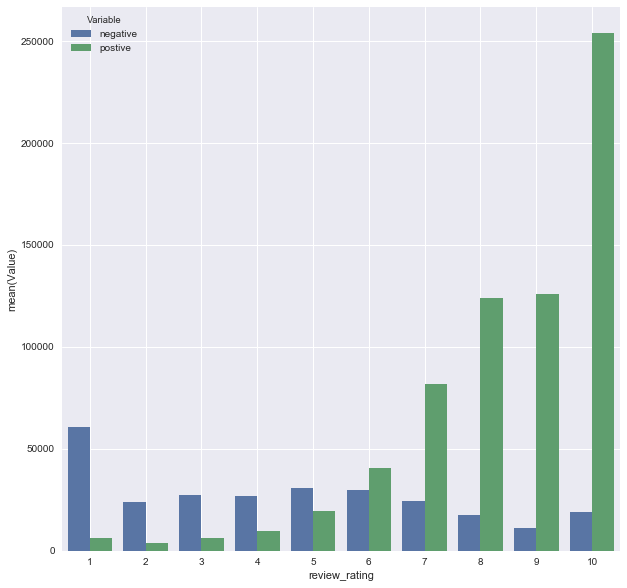

In [41]:
import seaborn as sea

sea.set_style('dark')

fig5 = plt.figure()

review_rating = np.asarray(review_rating)
negative = np.asarray(negative)
postive = np.asarray(postive)

df = pd.DataFrame({
    'review_rating':review_rating.tolist(),
    'negative':negative.tolist(),
    'postive':postive.tolist()
})
tidy = (
    df.set_index('review_rating')
      .stack()  # un-pivots the data 
      .reset_index()  # moves all data out of the index
      .rename(columns={'level_1': 'Variable', 0: 'Value'})
)
fig, ax1 = plt.subplots(figsize=(10, 10))
sea.barplot(x='review_rating', y='Value', hue='Variable', data=tidy, ax=ax1)
sea.despine(fig)
plt.grid(True)
plt.show()